ARIMA çalışmaları

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
stock = pd.read_csv('VESTL.csv', index_col=0, parse_dates=True)

Durağanlık kontrolü (Stationary)

In [48]:
from statsmodels.tsa.stattools import adfuller

In [49]:
def adf(x):
  res = adfuller(x)
  print("Test-Statistic:", res[0])
  print("P-Value:", res[1])
  if res[1] < 0.05:
    print("Stationary")
  else:
    print("Non-Stationary")

In [50]:
adf(stock['Price'])

Test-Statistic: -2.9974370105903807
P-Value: 0.035134445466536816
Stationary


In [23]:
stock_close = stock.drop(columns=['Open', 'High','Low','Vol.','Change %'])

In [24]:
stock_close = stock_close.sort_index()

In [25]:
stock_close.drop_duplicates()

,Price
Date,
2021-04-01,37.28
2021-04-02,36.80
2021-04-05,36.20
2021-04-06,36.28
2021-04-07,35.48
...,...
2021-08-11,28.78
2021-08-12,29.36
2021-08-16,29.72


In [26]:
stock_close =stock_close.reindex(pd.date_range(stock_close.index.min().to_datetime64(),stock_close.index.max().to_datetime64()))

In [27]:
stock_close.head(20)

,Price
2021-04-01,37.28
2021-04-02,36.80
2021-04-03,NaN
2021-04-04,NaN
2021-04-05,36.20
2021-04-06,36.28
2021-04-07,35.48
2021-04-08,37.00
2021-04-09,36.28
2021-04-10,NaN


In [28]:
 stock_close = stock_close.fillna(method='ffill')

In [30]:
stock_close['Diff'] = stock_close['Price'].diff()

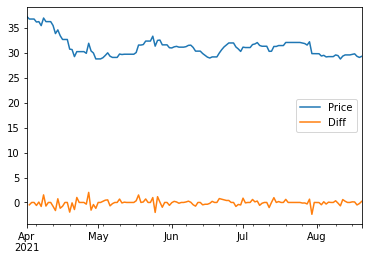

In [31]:
stock_close.plot()

In [32]:
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [35]:
stock_close.index.freq = 'D'

Ntest = 10
train = stock_close.iloc[:-Ntest]
test = stock_close.iloc[-Ntest:]

In [36]:
train_idx = stock_close.index <= train.index[-1]
test_idx = stock_close.index > train.index[-1]

In [37]:
arima = ARIMA(train['Price'], order=(1,0,0))

In [38]:
arima_result = arima.fit()

In [39]:
stock_close.loc[train_idx, 'AR(1)'] = arima_result.predict(start=train.index[0], end=train.index[-1])

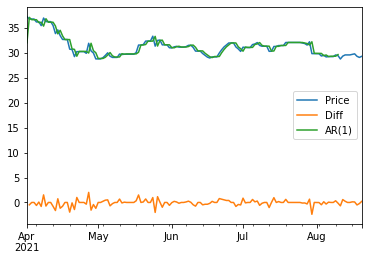

In [40]:
stock_close.plot()

In [41]:
forecast, stderr, confint = arima_result.forecast(Ntest)
stock_close.loc[test_idx, 'AR(1)'] = forecast

In [43]:
stock_close

,Price,Diff,AR(1)
2021-04-01,37.28,NaN,32.045636
2021-04-02,36.80,-0.48,37.132180
2021-04-03,36.80,0.00,36.665735
2021-04-04,36.80,0.00,36.665735
2021-04-05,36.20,-0.60,36.665735
...,...,...,...
2021-08-16,29.72,0.12,29.868324
2021-08-17,29.82,0.10,29.929812
2021-08-18,29.32,-0.50,29.989564
2021-08-19,29.10,-0.22,30.047628


In [44]:
def plot_fit_and_forecast(result):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(stock_close['Price'], label='data')

  # plot the curve fitted on train set
  train_pred = result.fittedvalues
  ax.plot(train.index, train_pred, color='green', label='fitted')

  # forecast the test set
  forecast, stderr, confint = result.forecast(Ntest)
  ax.plot(test.index, forecast, label='forecast')
  ax.fill_between(test.index, \
                  confint[:,0], confint[:,1], \
                  color='red', alpha=0.3)
  ax.legend()

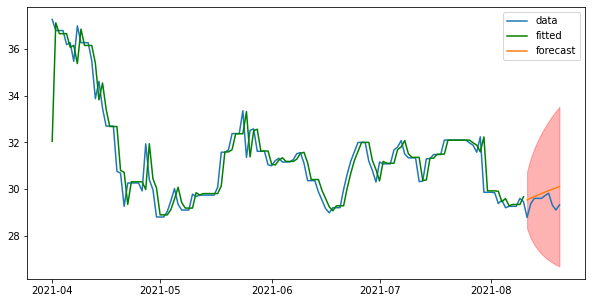

In [45]:
plot_fit_and_forecast(arima_result)

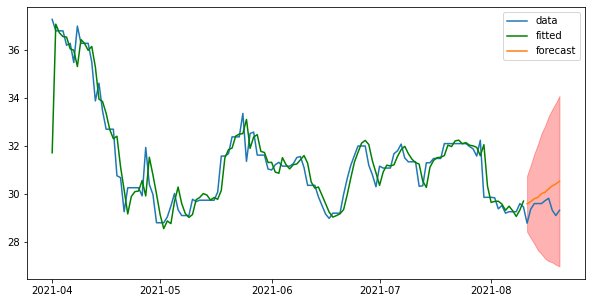

In [46]:
arima = ARIMA(train['Price'], order=(10,0,0)) # AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

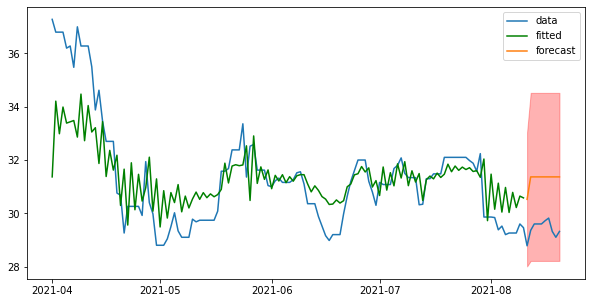

In [47]:
arima = ARIMA(train['Price'], order=(0,0,1)) # MA(1)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)